In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
import pickle 
from nba_api.stats.endpoints import playbyplayv2, leaguegamefinder
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from nba_helper import read_url_to_csv, read_data

from nba_helper import elo_url

import pandas as pd
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['NBA']

db.list_collection_names()

['historical_raptor',
 'player2k',
 'game_log',
 'shot_chart',
 'historical_pbp_modelled',
 'historical_pbp']

In [2]:
pbp = pd.DataFrame.from_records(db.historical_pbp.find())

In [4]:
pbp.head()

,_id,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,61d614c5f040a069488214dc,21500003,0,12,0,1,11:03 PM,12:00,None,Start of 1st Period (11:03 PM EST),None,None,None,0.0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
1,61d614c5f040a069488214dd,21500003,1,10,0,1,11:03 PM,12:00,Jump Ball Bogut vs. Davis: Tip to Robinson,None,None,None,None,4.0,101106,Andrew Bogut,1.610613e+09,Golden State,Warriors,GSW,5,203076,Anthony Davis,1.610613e+09,New Orleans,Pelicans,NOP,5,101126,Nate Robinson,1.610613e+09,New Orleans,Pelicans,NOP,1
2,61d614c5f040a069488214de,21500003,2,2,1,1,11:03 PM,11:46,None,None,MISS Davis 3PT Jump Shot,None,None,5.0,203076,Anthony Davis,1.610613e+09,New Orleans,Pelicans,NOP,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
3,61d614c5f040a069488214df,21500003,3,4,0,1,11:03 PM,11:45,Bogut REBOUND (Off:0 Def:1),None,None,None,None,4.0,101106,Andrew Bogut,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
4,61d614c5f040a069488214e0,21500003,4,1,1,1,11:03 PM,11:35,Green 26' 3PT Jump Shot (3 PTS) (Thompson 1 AST),None,None,0 - 3,3,4.0,203110,Draymond Green,1.610613e+09,Golden State,Warriors,GSW,4,202691,Klay Thompson,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,1


In [6]:
pbp.shape

(3553196, 35)

In [7]:
pbp = pbp.drop('_id', axis = 1)

In [8]:
pbp.to_csv('../Data/historical_pbp.csv', index=False)

In [4]:
%%time
pbp_prepped = feature_engineer(pbp)

CPU times: user 1min 22s, sys: 58.3 s, total: 2min 20s
Wall time: 2min 54s


In [6]:
elo = read_url_to_csv(elo_url)
elo = elo[elo['date'] > '2012-01-01']

elo.loc[:, 'elo_difference'] = np.abs(elo['elo1_pre'] - elo['elo2_pre'])

elo = elo[['date', 'team1', 'elo1_pre', 'elo2_pre', 'elo_difference']]

elo['team1'] = elo['team1'].replace({'BRK':'BKN',
                                     'PHO':'PHX',
                                    'CHO':'CHA',})

In [17]:
all_games = pd.DataFrame.from_records(db.game_log.find())

In [18]:
all_games[['Home', 'Away']] = all_games['MATCHUP'].str.split('vs.', expand=True)
all_games['Home'] = all_games['Home'].str.strip()
all_games['GAME_ID'] = all_games['GAME_ID'].astype(int)
all_games['home_team_win'] = all_games['WL'].replace({'W':1, 'L':0})

In [19]:
elo_w_game_ids = all_games.merge(elo, left_on=['GAME_DATE', 'Home'], right_on = ['date', 'team1'])

In [20]:
df = pbp_prepped.merge(elo_w_game_ids[['GAME_ID', 'elo1_pre', 'elo2_pre', 'elo_difference', 'home_team_win']], on = ['GAME_ID'])

In [21]:
df.head()

,GAME_ID,home_poss,diff,time_remaining,OT_ind,elo1_pre,elo2_pre,elo_difference,home_team_win
0,21500003,0,0,2880,0,1742.966075,1521.178175,221.7879,1
1,21500003,1,0,2880,0,1742.966075,1521.178175,221.7879,1
2,21500003,0,0,2866,0,1742.966075,1521.178175,221.7879,1
3,21500003,1,0,2865,0,1742.966075,1521.178175,221.7879,1
4,21500003,1,3,2855,0,1742.966075,1521.178175,221.7879,1


In [12]:
# db.historical_pbp_modelled.insert_many(df.to_dict('records'))

In [14]:
db.list_collection_names()

['historical_raptor',
 'player2k',
 'game_log',
 'shot_chart',
 'historical_pbp_modelled',
 'historical_pbp']

In [22]:
games = df['GAME_ID'].unique()

In [25]:
train_games = games[:7000]
test_games = games[7000:]
train = df[df['GAME_ID'].isin(train_games)].drop(['GAME_ID', 'elo_difference'], axis = 1)

X_train = train.drop(['home_team_win'], axis = 1)
y_train = train['home_team_win']


test = df[df['GAME_ID'].isin(test_games)]

X_test = test.drop(['home_team_win', 'GAME_ID'], axis = 1)
y_test = test['home_team_win']

In [26]:
model_wO_elo = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu', input_shape=[4,]),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_wO_elo.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model_wO_elo.summary()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu', input_shape=[6,]),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 

2022-01-15 09:16:42.987578: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
X_train_wO_elo = X_train.drop(['elo1_pre', 'elo2_pre'], axis = 1)

In [29]:
model_wO_elo.fit(X_train_wO_elo.values,
          y_train.values,
          verbose=1,
          shuffle=True,
          epochs=15,
          batch_size=512)

model.fit(X_train.values,
          y_train.values,
          verbose=1,
          shuffle=True,
          epochs=15,
          batch_size=512)

Epoch 1/15
6371/6371 [==============================] - 6s 788us/step - loss: 3.6358 - accuracy: 0.6735 - auc: 0.6892
Epoch 2/15
6371/6371 [==============================] - 5s 711us/step - loss: 2.2999 - accuracy: 0.6757 - auc: 0.6984
Epoch 3/15
6371/6371 [==============================] - 5s 707us/step - loss: 1.4122 - accuracy: 0.6797 - auc: 0.7144
Epoch 4/15
6371/6371 [==============================] - 4s 698us/step - loss: 0.6956 - accuracy: 0.6943 - auc: 0.7619
Epoch 5/15
6371/6371 [==============================] - 4s 696us/step - loss: 0.5357 - accuracy: 0.7175 - auc: 0.7969
Epoch 6/15
6371/6371 [==============================] - 5s 740us/step - loss: 0.4957 - accuracy: 0.7374 - auc: 0.8217
Epoch 7/15
6371/6371 [==============================] - 4s 698us/step - loss: 0.4927 - accuracy: 0.7395 - auc: 0.8241
Epoch 8/15
6371/6371 [==============================] - 5s 746us/step - loss: 0.4918 - accuracy: 0.7399 - auc: 0.8247
Epoch 9/15
6371/6371 [==============================] - 

In [30]:
model.save('../Models/TF_model_w_elo.h5')
model_wO_elo.save('../Models/TF_model_wO_elo.h5')

In [17]:
# model = tf.keras.models.load_model('../Models/TF_model_w_elo')
# model_wO_elo = tf.keras.models.load_model('../Models/TF_model_w0_elo')

In [47]:
X_train_wO_elo.columns

Index(['home_poss', 'diff', 'time_remaining', 'OT_ind'], dtype='object')

In [31]:
df.loc[:, 'preds_w_elo'] = model.predict_on_batch(df[X_train.columns])

df.loc[:, 'preds_wO_elo'] = model_wO_elo.predict_on_batch(df[X_train_wO_elo.columns])

In [43]:
db.list_collection_names()

['historical_raptor',
 'player2k',
 'game_log',
 'shot_chart',
 'historical_pbp_modelled',
 'historical_pbp']

In [44]:
db.historical_pbp_modelled.drop()

In [45]:
db.historical_pbp_modelled.insert_many(df.to_dict('records'))

In [33]:
test.loc[:, 'preds_w_elo'] = model.predict_on_batch(X_test[X_train.columns])

test.loc[:, 'preds_wO_elo'] = model_wO_elo.predict_on_batch(X_test[X_train_wO_elo.columns])

/Users/arun/Projects/NBA/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/arun/Projects/NBA/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [34]:
test

,GAME_ID,home_poss,diff,time_remaining,OT_ind,elo1_pre,elo2_pre,elo_difference,home_team_win,preds_w_elo,preds_wO_elo
3261524,22001028,0,1,2880,0,1541.747434,1501.032897,40.714537,1,0.584544,0.619525
3261525,22001028,1,1,2880,0,1541.747434,1501.032897,40.714537,1,0.583709,0.622191
3261526,22001028,1,1,2862,0,1541.747434,1501.032897,40.714537,1,0.584210,0.621330
3261527,22001028,1,1,2858,0,1541.747434,1501.032897,40.714537,1,0.584321,0.621138
3261528,22001028,1,2,2858,0,1541.747434,1501.032897,40.714537,1,0.601245,0.642050
...,...,...,...,...,...,...,...,...,...,...,...
3553191,22100581,0,17,34,0,1694.385602,1490.689779,203.695823,1,0.999897,1.000000
3553192,22100581,0,17,31,0,1694.385602,1490.689779,203.695823,1,0.999899,1.000000
3553193,22100581,0,17,23,0,1694.385602,1490.689779,203.695823,1,0.999904,1.000000
3553194,22100581,1,17,18,0,1694.385602,1490.689779,203.695823,1,0.999905,1.000000


In [35]:
from sklearn.metrics import brier_score_loss

In [36]:
brier_score_loss(test['home_team_win'], test['preds_w_elo'])

0.15495321224308004

In [37]:
brier_score_loss(test['home_team_win'], test['preds_wO_elo'])

0.1654293641223685

In [38]:
test = test.merge(test.groupby('GAME_ID').apply(lambda x: brier_score_loss(x['home_team_win'], x['preds_wO_elo'])).rename('brier_loss_wO_elo').reset_index(),
          on=['GAME_ID'])

In [39]:
test = test.merge(test.groupby('GAME_ID').apply(lambda x: brier_score_loss(x['home_team_win'], x['preds_w_elo'])).rename('brier_loss_w_elo').reset_index(),
          on=['GAME_ID'])

In [40]:
test.loc[:, 'brier_loss_diff'] = np.abs(test['brier_loss_w_elo'] - test['brier_loss_wO_elo'])

In [41]:
test.sort_values(by='brier_loss_diff', ascending=False)

,GAME_ID,home_poss,diff,time_remaining,OT_ind,elo1_pre,elo2_pre,elo_difference,home_team_win,preds_w_elo,preds_wO_elo,brier_loss_wO_elo,brier_loss_w_elo,brier_loss_diff
24511,22001074,0,-2,721,0,1227.838160,1633.740769,405.902610,1,0.195942,0.509828,0.163852,0.544678,0.380826
24469,22001074,0,-7,1029,0,1227.838160,1633.740769,405.902610,1,0.108807,0.303200,0.163852,0.544678,0.380826
24480,22001074,0,-6,984,0,1227.838160,1633.740769,405.902610,1,0.115584,0.327696,0.163852,0.544678,0.380826
24479,22001074,1,-6,987,0,1227.838160,1633.740769,405.902610,1,0.115119,0.324217,0.163852,0.544678,0.380826
24478,22001074,0,-6,1000,0,1227.838160,1633.740769,405.902610,1,0.116460,0.330497,0.163852,0.544678,0.380826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208882,22100393,0,9,1923,0,1541.258272,1431.180174,110.078098,1,0.818704,0.815451,0.018846,0.018787,0.000059
208881,22100393,1,11,1931,0,1541.258272,1431.180174,110.078098,1,0.843198,0.859752,0.018846,0.018787,0.000059
208880,22100393,1,11,1931,0,1541.258272,1431.180174,110.078098,1,0.843198,0.859752,0.018846,0.018787,0.000059
208879,22100393,1,11,1944,0,1541.258272,1431.180174,110.078098,1,0.842547,0.859111,0.018846,0.018787,0.000059


In [42]:
live_pbp = test[['GAME_ID', 'home_poss', 'diff', 'time_remaining', 'OT_ind', 'preds_wO_elo']]

In [85]:
live_pbp.columns = ['game_id', 'home_poss', 'diff', 'time_remaining', 'OT_ind', 'prob']

In [89]:
import sqlite3 as sq

conn = sq.connect('../Data/NBA.sqlite')
live_pbp.to_sql('live_pbp', conn, if_exists = 'replace', index=False)

In [64]:
test_game = test[test['GAME_ID'] == 22001074]


In [68]:
plot_data = test_game[['time_remaining', 'preds_w_elo', 'preds_wO_elo']]

<AxesSubplot:>

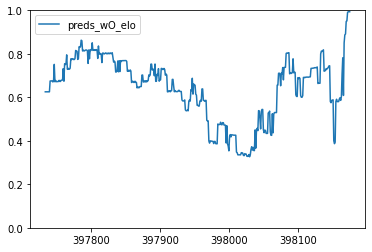

In [77]:
plot_data.plot(y='preds_wO_elo', ylim=[0,1])

In [73]:
from nba_api.stats.endpoints import winprobabilitypbp

pbpw = winprobabilitypbp.WinProbabilityPBP('0022001074').get_data_frames()

<AxesSubplot:>

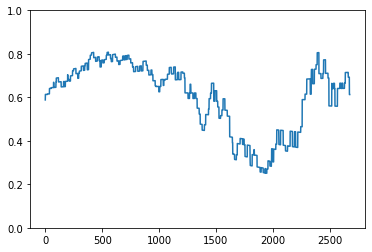

In [74]:
pbpw[0].HOME_PCT.plot(ylim = [0,1])

In [63]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_game['time_remaining'][::-1], y=test_game['preds_w_elo'],
                    mode='lines', name='win prob with elo'))

fig.add_trace(go.Scatter(x = test_game['time_remaining'][::-1], y=test_game['preds_wO_elo'],
                    mode='lines', name='win prob'))

fig.add_vline(x=720, line_width=3, line_dash="dash", line_color="green", name='Q1')
fig.add_vline(x=1440, line_width=3, line_dash="dash", line_color="green", name='Q1')
fig.add_vline(x=2160, line_width=3, line_dash="dash", line_color="green", name='Q1')



fig.show()

In [31]:
from nba_api.stats.endpoints import playbyplayv2

pbp = playbyplayv2.PlayByPlayV2('0022100525').get_data_frames()[0]

pbp

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022100525,2,12,0,1,7:12 PM,12:00,None,Start of 1st Period (7:12 PM EST),None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
1,0022100525,4,10,0,1,7:12 PM,12:00,Jump Ball Aldridge vs. Embiid: Tip to Curry,None,None,None,None,4,200746,LaMarcus Aldridge,1.610613e+09,Brooklyn,Nets,BKN,5,203954,Joel Embiid,1.610613e+09,Philadelphia,76ers,PHI,5,203552,Seth Curry,1.610613e+09,Philadelphia,76ers,PHI,1
2,0022100525,49,5,2,1,7:12 PM,11:42,Harden STEAL (1 STL),None,Embiid Lost Ball Turnover (P1.T1),None,None,5,203954,Joel Embiid,1.610613e+09,Philadelphia,76ers,PHI,4,201935,James Harden,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,1
3,0022100525,10,2,6,1,7:12 PM,11:36,MISS Harden 5' Driving Layup,None,None,None,None,4,201935,James Harden,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
4,0022100525,11,4,0,1,7:12 PM,11:34,Claxton REBOUND (Off:1 Def:0),None,None,None,None,4,1629651,Nic Claxton,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0022100525,689,2,1,4,9:23 PM,0:05,MISS Harden 26' 3PT Jump Shot,None,Thybulle BLOCK (2 BLK),None,None,4,201935,James Harden,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,5,1629680,Matisse Thybulle,1.610613e+09,Philadelphia,76ers,PHI,1
472,0022100525,691,4,0,4,9:23 PM,0:01,Harden REBOUND (Off:3 Def:11),None,None,None,None,4,201935,James Harden,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
473,0022100525,692,2,1,4,9:23 PM,0:00,MISS Aldridge 6' Jump Shot,None,None,None,None,4,200746,LaMarcus Aldridge,1.610613e+09,Brooklyn,Nets,BKN,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
474,0022100525,693,4,0,4,9:23 PM,0:00,None,None,Embiid REBOUND (Off:2 Def:5),None,None,5,203954,Joel Embiid,1.610613e+09,Philadelphia,76ers,PHI,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1


In [33]:
from preprocess import *

In [36]:
elo.query("date == '2021-12-30'")

,date,team1,elo1_pre,elo2_pre,elo_difference
71234,2021-12-30,BRK,1611.241573,1576.527816,34.713757
71235,2021-12-30,ORL,1310.797644,1609.221441,298.423798
71236,2021-12-30,WAS,1461.068662,1591.958200,130.889538


In [37]:
recent_game = feature_engineer(pbp).assign(elo1_pre = 1611.241573, elo2_pre = 1576.527816)

In [40]:
recent_game = recent_game[X_train.columns]

In [41]:
recent_game_wO_elo = recent_game[X_train_wO_elo.columns]

In [42]:
recent_game.loc[:, 'preds_w_elo'] = model.predict_on_batch(recent_game[X_train.columns])

recent_game.loc[:, 'preds_wO_elo'] = model_wO_elo.predict_on_batch(recent_game[X_train_wO_elo.columns])

/Users/arun/Projects/NBA/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/arun/Projects/NBA/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_game['time_remaining'][::-1], y=test_game['preds_w_elo'],
                    mode='lines', name='win prob with elo'))

fig.add_trace(go.Scatter(x = test_game['time_remaining'][::-1], y=test_game['preds_wO_elo'],
                    mode='lines', name='win prob'))

fig.add_vline(x=720, line_width=3, line_dash="dash", line_color="green", name='Q1')
fig.add_vline(x=1440, line_width=3, line_dash="dash", line_color="green", name='Q1')
fig.add_vline(x=2160, line_width=3, line_dash="dash", line_color="green", name='Q1')



fig.show()

In [43]:
def plot_game(df):
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = df['time_remaining'][::-1], y=df['preds_w_elo'],
                        mode='lines', name='win prob with elo'))

    fig.add_trace(go.Scatter(x = df['time_remaining'][::-1], y=df['preds_wO_elo'],
                        mode='lines', name='win prob'))

    fig.add_vline(x=720, line_width=3, line_dash="dash", line_color="green", name='Q1')
    fig.add_vline(x=1440, line_width=3, line_dash="dash", line_color="green", name='Q1')
    fig.add_vline(x=2160, line_width=3, line_dash="dash", line_color="green", name='Q1')



    fig.show()

In [44]:
plot_game(recent_game)

In [ ]:
'''
how to do this! 

you need to continuously call the api and sleep accordingly depending on timeout/half time etc

when you call the api compare it with the most recent json you have 
if the json are the same
leave it
if theyre not the same then make sure you push the new json to the database and make the curr_json the new json to compare w for future api calls

on the other side create an event to say when the database updates trigger an event to update the win probabilities and subsequently plot the graphs'''